In [2]:
#### Creating layer: Number of previous fires

# Take image for a given fire scar

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from rasterio.mask import mask
import rasterio
import geopandas as gpd
from rasterio.plot import show
import rasterio.features
import rasterio.warp
from matplotlib import pyplot
import geopandas as gdp
from rasterio.warp import reproject, Resampling
from rasterio.transform import rowcol
from rasterio.windows import Window
from rasterio.merge import merge
import pandas as pd
from glob import glob


base_folder = "Fire_CL-ML_Maule"
output_dir = "merged_rasters"
os.makedirs(output_dir, exist_ok=True)


# perform cropping, padding and centering as in pre-processing 
df = pd.read_excel("FireScar_CL_Summary_1985-2018.xlsx") #excel meta-data file with file names and locations
df = df[df['FireScar'] == 1]  # Filter to just files that have fire scar available
df = df[df['Region_CONAF'] == 'Maule'] # Filter to just Maule
df = df.reset_index()

regions = gpd.read_file("Regiones/Regional.shp")
# Fix coordinate reference system 
regions = regions.to_crs("EPSG:4326")
maule_poly = regions[regions['Region'] == 'Región del Maule'] 
maule_geom = maule_poly.geometry.values

if maule_poly.empty:
    raise ValueError("No 'Maule' region found in shapefile.")


In [6]:
for year, group in df.groupby('FireSeason'):
    print(f"\nProcessing year {year}")
    clipped_arrays = []
    clipped_transforms = []

    for _, row in group.iterrows():
        raster_path = os.path.join(base_folder, row['FolderLocation'], row['FireScarImgName'])

        if not os.path.exists(raster_path):
            print(f"❌ Missing: {raster_path}")
            continue

        try:
            with rasterio.open(raster_path) as src:
                # Reproject shapefile to raster CRS
                maule_proj = maule_poly.to_crs(src.crs)
                # Clip to maule
                clipped, transform = mask(src, maule_proj.geometry, crop=True, filled=True, nodata=0)
                clipped_arrays.append(clipped)
                clipped_transforms.append(transform)
        except Exception as e:
            print(f"⚠️ Failed to process {raster_path}: {e}")

    # === Merge all the clipped rasters ===
    if clipped_arrays:
        mosaic, out_transform = merge(
            [(arr, transform) for arr, transform in zip(clipped_arrays, clipped_transforms)],
            method='max',
            nodata=0
            )
        out_meta = src.meta.copy()
        out_meta.update({
            "height": mosaic.shape[1],
            "width": mosaic.shape[2],
            "transform": out_transform,
            "driver": "GTiff",
            "nodata": 0
        })

        out_path = os.path.join(output_dir, f"Maule_FireScars_{year}_clipped.tif")
        with rasterio.open(out_path, "w", **out_meta) as dest:
            dest.write(mosaic)
        print(f"✅ Saved clipped mosaic: {out_path}")
    else:
        print(f"⚠️ No valid rasters for year {year}")


Processing year 1986


AttributeError: 'tuple' object has no attribute 'profile'

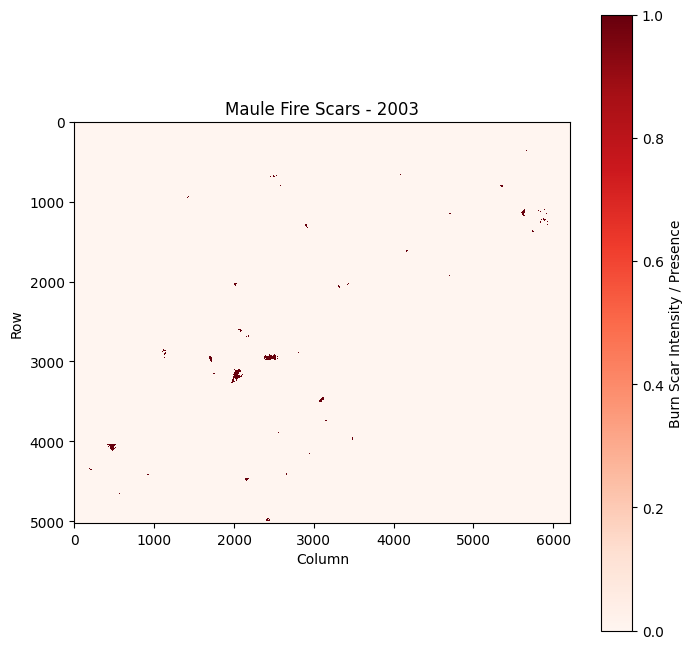

In [139]:
raster_path = "merged_rasters/Maule_FireScars_2003.tif"

# Open and plot
with rasterio.open(raster_path) as src:
    data = src.read(1)  # Read the first band
    plt.figure(figsize=(8, 8))
    plt.imshow(data, cmap='Reds', interpolation='none')
    plt.colorbar(label="Burn Scar Intensity / Presence")
    plt.title("Maule Fire Scars - 2003")
    plt.xlabel("Column")
    plt.ylabel("Row")
    plt.grid(False)
    plt.show()

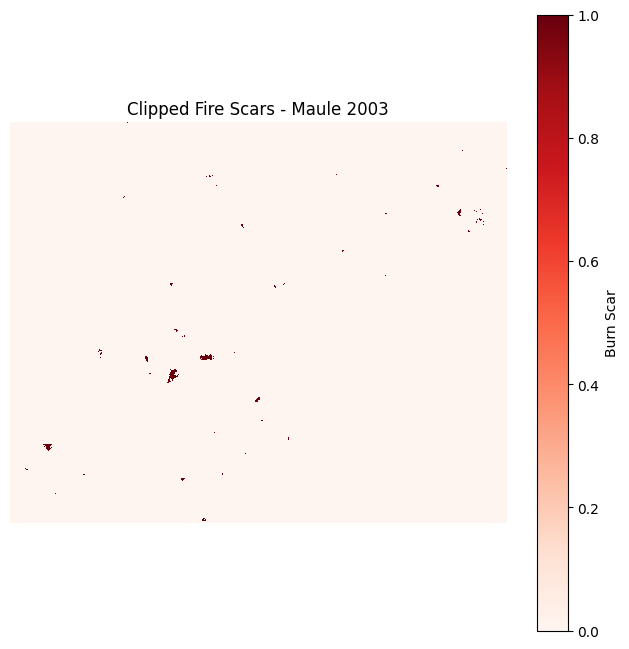

In [140]:
with rasterio.open(raster_path) as src:
    # Reproject vector to raster CRS if needed
    if maule.crs != src.crs:
        maule = maule.to_crs(src.crs)

    # Clip raster
    out_image, out_transform = mask(src, maule.geometry, crop=True)
    out_meta = src.meta.copy()
    out_meta.update({
        "height": out_image.shape[1],
        "width": out_image.shape[2],
        "transform": out_transform
    })

# === Plot clipped raster ===
plt.figure(figsize=(8, 8))
plt.imshow(out_image[0], cmap='Reds', interpolation='none')
plt.title("Clipped Fire Scars - Maule 2003")
plt.axis('off')
plt.colorbar(label="Burn Scar")
plt.show()

In [112]:
fire_id = 'ID142593' # look at first event
example_fire = df[df['FireID'] == fire_id]

overlap_fires = example_fire['OverlapIDs']
example_fire_id = example_fire['FireID']
overlap_fires
overlap_fire_ids = overlap_fires.iloc[0].split(', ')


In [97]:
example_fire_id

232    ID142593
Name: FireID, dtype: object

In [113]:
overlap_fire_ids

['ID142595', 'ID142642']

In [98]:
fire_season

2003

In [103]:
fire_season = example_fire["FireSeason"].iloc[0]
img_name = example_fire["FireScarImgName"].iloc[0]

folder = f"Fire_CL-ML_Maule/FireScar_CL-ML_Maule_{fire_season}"
file_names = {
        "Fire Scar": (example_fire["FireScarImgName"], "Reds"),
        "RdNBR": (example_fire["RdNBRImgName"], "Reds"),
        "Severity": (example_fire["SeverityImgName"], "Blues"),
    }

fire_scar_path = os.path.join(folder, img_name)


In [122]:
# Eventually turn into loop to account for multipl overlaps
overlap_fire = df[df['FireID'] == overlap_fire_ids[1]]

overlap_fire_season = overlap_fire["FireSeason"].iloc[0]

# If overlap fire season is not equal to the fire season

overlap_img_name = overlap_fire["FireScarImgName"].iloc[0]

overlap_folder = f"Fire_CL-ML_Maule/FireScar_CL-ML_Maule_{overlap_fire_season}"

overlap_fire_scar_path = os.path.join(overlap_folder, overlap_img_name)

In [123]:
overlap_fire_ids[1]

'ID142642'

In [124]:
overlap_fire

,index,FireID,FireSeason,RegionCode,Region_CONAF,FireName_CONAF,Area_CONAF [ha],IgnitionDate_CONAF,ControlDate_CONAF,Latitude [°],...,Height [pixels],TotalArea [m2],AreaUnchS [m2],AreaLowS [m2],AreaModS [m2],AreaHighS [m2],FireScarPolygons,SeverityPolygons,OverlapIDs,Observations
239,2798,ID142642,2009,CL-ML,Maule,LA UNION,1033.0,2009-01-16,2009-01-31,-35.0071,...,255.0,1.250736e+07,0.0,0.0,4.820228e+06,7.687132e+06,30.0,704.0,"ID142593, ID142595",NaN


In [125]:
example_fire

,index,FireID,FireSeason,RegionCode,Region_CONAF,FireName_CONAF,Area_CONAF [ha],IgnitionDate_CONAF,ControlDate_CONAF,Latitude [°],...,Height [pixels],TotalArea [m2],AreaUnchS [m2],AreaLowS [m2],AreaModS [m2],AreaHighS [m2],FireScarPolygons,SeverityPolygons,OverlapIDs,Observations
232,2748,ID142593,2009,CL-ML,Maule,LA AGUADILLA,201.0,2009-03-07,2009-03-09,-34.9847,...,61.0,1.746262e+06,0.0,0.0,158888.298401,1.587374e+06,3.0,87.0,"ID142595, ID142642",NaN


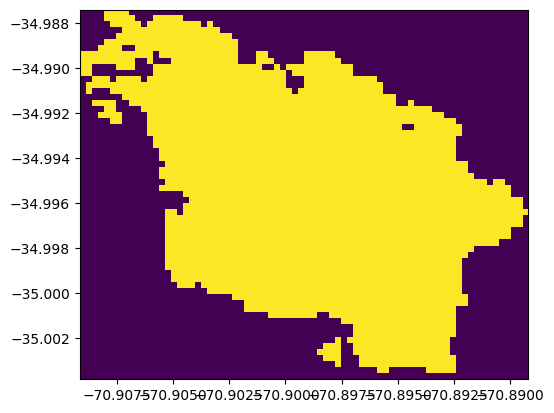

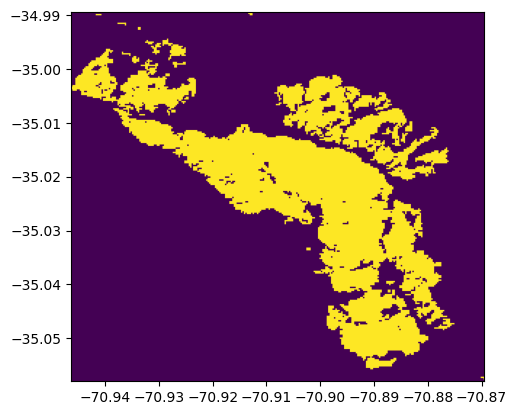

<Axes: >

In [126]:
fire_scar = rasterio.open(fire_scar_path)
severity = rasterio.open(severity_path)
overlap = rasterio.open(overlap_fire_scar_path)
show(fire_scar)
show(overlap)

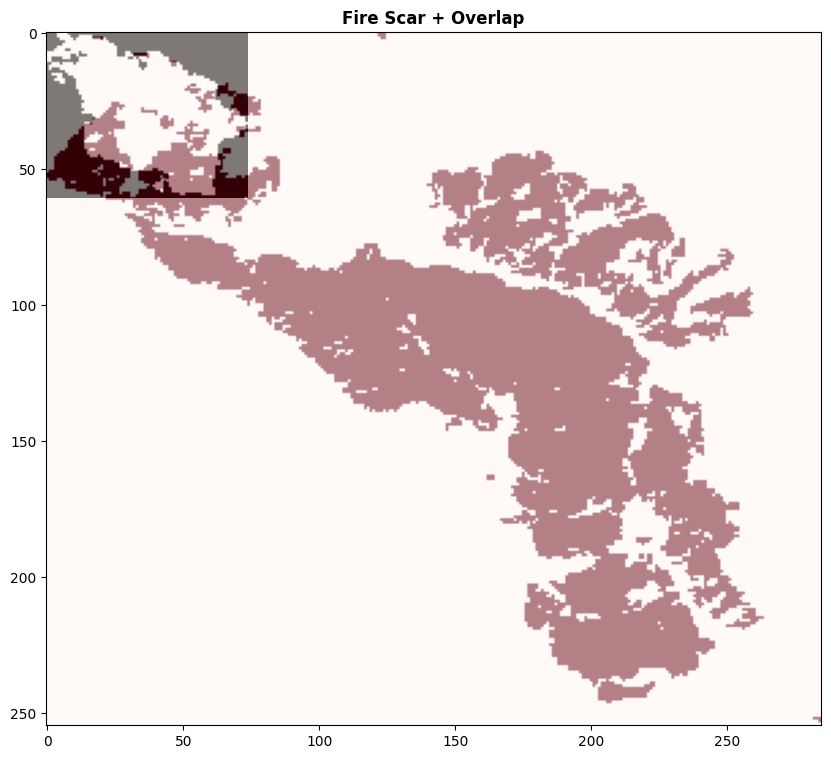

In [127]:
# Read image arrays (assuming single band)
fire_scar_data = fire_scar.read(1)
overlap_data = overlap.read(1)

# Plot using matplotlib
fig, ax = plt.subplots(figsize=(10, 10))

# Show the base layer (fire_scar) in grayscale
show(fire_scar_data, ax=ax, cmap='gray', title='Fire Scar + Overlap')

# Overlay the second layer (overlap) with transparency
show(overlap_data, ax=ax, cmap='Reds', alpha=0.5)

plt.show()

1

In [ ]:
# Iterate through fire IDs. For each ID:

# Find the IDs of fire scar events that have an overlapping fire

# If fire scar has no overlapping IDs, save a raster of 0s with same shape

# If only one previous scar, save layer of this previous scar values (1 and 0)

# If more than one previous scar, the layer should be the sum of all these scars

# Save as additional band to original fire scar

# Project all into same geographic space

# Take the sum of the layers (should give total number of previous fires)